In [16]:
import seaborn as sns
sns.set_style("whitegrid")
from process_model import *
from fit_process import *

from scipy.stats import norm
from scipy.stats.mstats import mquantiles
    
#from chase.base import *
#from chase.utils import *
#from chase.fit import *

import pickle

PARS = {'theta': [0, 100, 3],
        'p_stay': [0, 1, .1],
        'p_fixed': [0, 1, .1],
        'p_stop_geom': [0, 1, .5],
        'tau': [.001, 50],
        'tau_unif': [0, 1],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., 5],
        'w_loss': [0., 10]}

#FIGDEST = '/Users/markant/Dropbox/Apps/ShareLaTeX/ssDFE/ssDFE_v3/figures/'

def expected_value(options):
    values = options[:,:,0]
    weights = options[:,:,1]

    # expected value of each outcome
    v = np.array([np.multiply(weights[i], values[i]) for i in range(len(options))])

    return np.sum(v, 1)


def evar(options):

    values = options[:,:,0]
    weights = options[:,:,1]

    # expected value of each outcome
    v = np.array([np.multiply(weights[i], values[i]) for i in range(len(options))])

    # expected variance of each option
    evar = np.array([np.dot(weights[i], values[i] ** 2) - np.sum(v[i]) ** 2 for i in range(len(options))])

    return evar

def max_ev(options):
    ev = expected_value(options)
    if ev[0] > ev[1]:
        return [1, 0]
    else:
        return [0, 1]


def max_var(options):
    v = evar(options)
    if v[0] > v[1]:
        return [1, 0]
    else:
        return [0, 1]
    
def cv(options):
    ev = expected_value(options)
    sd = np.sqrt(evar(options))    
    return sd / ev


def max_cv(options):
    v = cv(options)
    if v[0] > v[1]:
        return [1, 0]
    else:
        return [0, 1]
    
def pfix(p):
    c = 1e-5
    return np.min([np.max([p, c]), 1 - c])


P_STOP_GEOM = {'HBWE': .053418,
               'HPKH1': 0.07666,
               'HPKH2': 0.02627}

P_SWITCH = {'HBWE': .25,
            'HPKH1': .185,
            'HPKH2': .11}

cp = {}
bf_cp = {}

quant = {}
bf_quant = {}

N_ITER = 1

def problem_array(row):
    return np.array([[row[['g1o1', 'g1p1']].values, row[['g1o2', 'g1p2']].values],
                     [row[['g2o1', 'g2p1']].values, row[['g2o2', 'g2p2']].values]])


def load_problem_set(experiment):

    problems = {}

    data = pd.read_csv('paper/data/glockner2016/Glockner2016_EB_all.csv', index_col=0)
    data = data[(data.description==0) & (data.exp==experiment)]
    probdf = data[['g1o1', 'g1p1', 'g1o2', 'g1p2', 'g2o1', 'g2p1', 'g2o2', 'g2p2']].drop_duplicates().reset_index()

    for i, row in probdf.iterrows():
        p = problem_array(row)
        print p
        evA, evB = expected_value(p)
        print evA, evB

        if evA > evB:
            problems[i] = np.array([p[1], p[0]])
        else:
            problems[i] = p

    return problems

In [ ]:
coding = max_cv(problems[0])

In [36]:
def load_data_and_problems(experiment):
    
    data = pd.read_csv('paper/data/glockner2016/Glockner2016_EB_all.csv', index_col=0)
    data = data[(data.description==0) & (data.exp==experiment)]
    data.rename(columns={'subj': 'subject', 'dec': 'choice', 'samples': 'samplesize'}, inplace=True)
    data['choice'] = data['choice'] - 1
    data['group'] = 0
    
    problems = {}
    psets_str = []

    arr = []
    for i, row in df.iterrows():

        pa = problem_array(row[['g1o1', 'g1p1', 'g1o2', 'g1p2', 'g2o1', 'g2p1', 'g2o2', 'g2p2']])
        evA, evB = expected_value(pa)
        if evA > evB:
            pa = np.array([pa[1], pa[0]])


        pa_str = np.array_str(pa)

        if pa_str in psets_str:
            i = psets_str.index(pa_str)
        else:
            i = len(psets_str)
            problems[i] = pa
            psets_str.append(pa_str)
        arr.append(i)
        
    data['problem'] = np.array(arr)
    
    return data, problems

# Fit GFHAH12

In [37]:
data, problems = load_data_and_problems(1)

In [63]:
SIM_ID = 'process_glockner2016_exp1'
OUTDIR = 'process_fitresults_glockner2016_exp1'

FIXED = {'minsamplesize': 2, 'pref_units': 'sums'}
PARSETS = [['theta', 'tau', 'prelec_gamma', 'prelec_elevation']]

m = CHASEProcessModel(problems=problems,
                      startdist='laplace')

In [65]:
for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    results = fit_mlh(m, problems, data, 
                      SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

prelec_elevation	prelec_gamma	tau	theta
[  1.10000000e-02   2.23200000e+00   1.64300000e+01   5.27910000e+01] 9731.81551668
[  0.894   1.706  11.821  65.276] 7061.70950673
[  0.209   0.256  14.257  44.37 ] 9639.93042904
[  2.398   2.817  13.441  45.994] 7824.76321412
[  2.476   0.204  19.689  80.559] 8895.78901261
[  2.867   0.89   30.135  61.268] 8513.91820093
[ 0.305  1.411  4.199  4.905] 14931.4792583
[  0.769   0.636  29.866  49.973] 7568.7405781
[  2.747   1.246   0.842  47.384] 8243.11492464
[  0.98    0.39   48.865   1.351] 15314.2603975
[  2.124   1.011  47.892  93.438] 8109.7419436
[  2.031   0.71   26.357  78.883] 7906.97225158
[  1.217   2.04    5.183  85.356] 7094.49517302
[  0.16    1.522  27.088  30.399] 11437.9774626
[  1.737   1.837  20.078  62.216] 7265.59164522
[  0.614   1.907  24.608  50.911] 7804.43106766
[  0.081   2.996   6.177  27.617] 12190.4433291
[  0.37    0.814   2.432  12.697] 14203.5398002
[  1.032   0.488  21.577  68.472] 7043.64097787
[  1.502   0.595  

In [66]:
best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
pred = predict_from_result(m, problems, SIM_ID, FIXED, 
                           fitting = fitting, 
                           outdir=OUTDIR)
print best

index                                                               0
Unnamed: 0                                                          0
iteration                                                           0
success                                                          True
nllh                                                          6918.47
k                                                                   4
N                                                                1273
bic                                                           13865.5
prelec_elevation                                              0.70417
prelec_gamma                                                 0.967609
tau                                                           3.52984
theta                                                         87.6068
sim_id              process_glockner2016_exp1(prelec_elevation,pre...
Name: 0, dtype: object


In [67]:
cp[SIM_ID] = data.groupby('problem').apply(lambda d: np.mean(d.choice))
bf_cp[SIM_ID] = np.array([np.mean(pred[pid]['choice']) for pid in problems])

quant[SIM_ID] = mquantiles(data.samplesize)
bf_quant[SIM_ID] = np.array([mquantiles(pred[pid]['samplesize']) for pid in problems]).mean(axis=0)

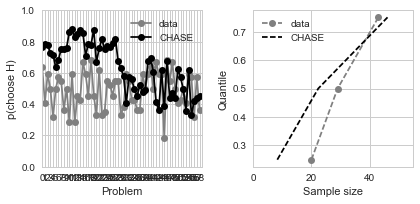

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
axi = ax[0]
axi.plot(range(len(problems)), cp[SIM_ID].values, '-o',
         color='gray', label='data')
axi.plot(range(len(problems)), bf_cp[SIM_ID], '-o', color='black', label='CHASE')
axi.set_ylim(0, 1)
axi.set_xlim(0, len(problems))
axi.set_xticks(range(len(problems)))
axi.set_xlabel('Problem')
axi.set_ylabel('p(choose H)')
axi.legend()

axi = ax[1]
axi.plot(quant[SIM_ID], [.25, .5, .75], '--o', color='gray', label='data')
axi.plot(bf_quant[SIM_ID], [.25, .5, .75], '--x', color='black', label='CHASE')

axi.set_xlim(0, 55)
axi.legend(loc='upper left')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')

plt.tight_layout()
plt.show()

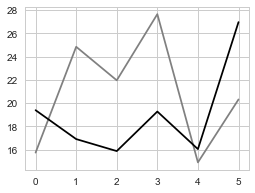

In [347]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(data.groupby('problem').apply(lambda d: np.mean(d.samplesize)), color='gray')
ax.plot(np.array([np.mean(pred[pid]['samplesize']) for pid in problems]), color='black')
plt.show()

# Hau et al 2008

In [310]:
SIM_ID = 'process_hau_exp1'
OUTDIR = 'process_fitresults_hau_exp1'
data = pd.read_csv('paper/data/hau2008/hau_data.csv', index_col=0)
data = data[data.group==1]

In [311]:
for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='laplace')
    results = fit_mlh(m, problems, data, 
                      SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

p_stay	prelec_elevation	prelec_gamma	tau	theta
[  0.061   2.031   1.727  38.543   5.76 ] 1510.86532976
[  2.90000000e-02   1.68700000e+00   1.22000000e-01   4.74880000e+01
   6.03800000e+00] 1204.32711237
[  0.582   2.18    1.36   26.941   2.031] 1509.30447795
[ 0.683  2.245  2.486  4.609  9.884] 1779.09571405
[  0.817   0.248   2.168  21.109   9.421] 1164.06388421
[  0.922   0.812   2.714  49.639   0.415] 1192.33294295
[  0.413   2.637   1.861  17.84    6.685] 1545.86363502
[  0.239   1.354   2.067  42.906   0.908] 1690.0812727
[  0.137   0.763   0.483  16.145   3.875] 1274.0752296
[ 0.778  0.708  0.679  9.65   9.195] 1161.54938023
[  0.147   2.934   0.768  32.901   9.707] 1332.68642951
[  0.738   1.935   0.919  24.008   2.84 ] 1171.03869876
[  0.297   2.863   1.032  26.566   0.645] 1559.2913171
[  0.243   2.458   2.379  19.891   3.099] 1814.42879353
[  0.508   2.965   0.204  22.173   5.12 ] 1278.55448782
[ 0.838  1.519  1.556  8.24   2.694] 1323.17497854
[ 0.452  1.623  2.613  2.973 

In [312]:
best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
pred = predict_from_result(m, problems, SIM_ID, FIXED, 
                           fitting = fitting, 
                           outdir=OUTDIR)
print best
cp[SIM_ID] = data.groupby('problem').apply(lambda d: np.mean(d.choice))
bf_cp[SIM_ID] = np.array([np.mean(pred[pid]['choice']) for pid in problems])

quant[SIM_ID] = mquantiles(data.samplesize)
bf_quant[SIM_ID] = np.array([mquantiles(pred[pid]['samplesize']) for pid in problems]).mean(axis=0)

index                                                               0
Unnamed: 0                                                          0
iteration                                                           0
success                                                          True
nllh                                                          947.388
k                                                                   5
N                                                                 230
bic                                                           1921.97
p_stay                                                       0.751302
prelec_elevation                                             0.470632
prelec_gamma                                                 0.749573
tau                                                           17.6592
theta                                                         4.24376
sim_id              process_hau_exp1(p_stay,prelec_elevation,prele...
Name: 0, dtype: obje

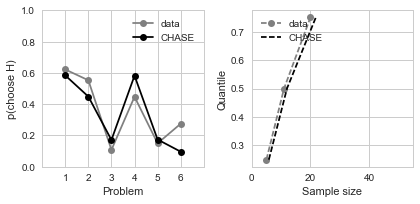

In [313]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
axi = ax[0]
axi.plot(range(1, 7), cp[SIM_ID].values, '-o',
         color='gray', label='data')
axi.plot(range(1, 7), bf_cp[SIM_ID], '-o', color='black', label='CHASE')
axi.set_ylim(0, 1)
axi.set_xlim(0, 7)
axi.set_xticks(range(1,7))
axi.set_xlabel('Problem')
axi.set_ylabel('p(choose H)')
axi.legend()

axi = ax[1]
axi.plot(quant[SIM_ID], [.25, .5, .75], '--o', color='gray', label='data')
axi.plot(bf_quant[SIM_ID], [.25, .5, .75], '--x', color='black', label='CHASE')

axi.set_xlim(0, 55)
axi.legend(loc='upper left')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')

plt.tight_layout()
plt.show()

In [314]:
SIM_ID = 'process_hau_exp2'
OUTDIR = 'process_fitresults_hau_exp2'
data = pd.read_csv('paper/data/hau2008/hau_data.csv', index_col=0)
data = data[data.group==2]

In [318]:
FIXED = {'minsamplesize': 2, 'max_T': 300}
PARSETS = [['theta', 'tau_unif', 'p_stay', 'prelec_gamma', 'prelec_elevation']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform')
    results = fit_mlh(m, problems, data, 
                      SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

p_stay	prelec_elevation	prelec_gamma	tau_unif	theta
[ 0.54   0.885  2.785  0.622  7.456] 2909.83598777
[ 0.597  2.789  1.671  0.757  1.704] 2873.0597385
[ 0.19   0.775  1.599  0.892  6.27 ] 2192.30959572
[ 0.767  2.318  1.936  0.544  8.022] 2638.19023788
[ 0.046  0.81   2.43   0.164  0.571] 3171.42123996
[ 0.304  2.452  2.961  0.428  0.341] 3304.91958539
[ 0.904  0.021  1.098  0.246  7.658] 1832.90450154
[ 0.667  1.038  1.855  0.118  3.517] 2432.67134794
[ 0.315  1.541  0.033  0.485  2.612] 2831.42674179
[ 0.953  1.229  0.297  0.412  0.652] 1915.47679751
[ 0.377  0.645  1.83   0.663  6.398] 2236.75904891
[ 0.525  0.179  1.142  0.317  7.269] 2264.01057125
[ 0.581  2.885  0.807  0.336  4.887] 3412.7882197


process_model.py:253: RuntimeWarning: invalid value encountered in divide
  p_stop_A = p_stop_A/float(p_stop_A.sum())


[ 0.232  2.727  0.134  0.06   5.1  ] 3088.91277675
[ 0.401  0.379  2.6    0.277  9.089] 2386.86024041
[ 0.867  1.171  0.475  0.129  6.541] 2190.19891439
[ 0.614  2.221  1.416  0.973  4.287] 2463.51465398
[ 0.101  2.603  0.67   0.419  0.174] 3094.37004659
[ 0.99   0.676  0.564  0.456  7.028] 2438.20312663
[ 0.549  0.132  0.502  0.017  4.03 ] 2244.39560253
[ 0.727  0.537  1.611  0.394  7.103] 1509.80110391
[ 0.439  2.112  1.308  0.361  6.773] 2766.59993466
[ 0.495  2.431  1.534  0.321  9.22 ] 2890.75263765
[  8.06000000e-01   2.32300000e+00   2.05600000e+00   3.00000000e-03
   5.65400000e+00] 2877.29570017
[ 0.564  0.264  2.496  0.91   2.383] 2327.03853323
[ 0.507  1.851  1.278  0.987  8.324] 2410.42599275
[ 0.24   0.343  1.082  0.043  7.507] 2371.10196966
[ 0.7    2.519  2.295  0.473  6.92 ] 2627.05768329
[ 0.288  2.005  1.969  0.301  7.948] 3193.80613261
[ 0.69   2.676  2.806  0.5    1.029] 2885.09968967
[ 0.07   0.44   1.357  0.14   8.761] 2193.61182587
[ 0.084  1.453  1.236  0.383  1

In [319]:
best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
pred = predict_from_result(m, problems, SIM_ID, FIXED, 
                           fitting = fitting, 
                           outdir=OUTDIR)
print best
cp[SIM_ID] = data.groupby('problem').apply(lambda d: np.mean(d.choice))
bf_cp[SIM_ID] = np.array([np.mean(pred[pid]['choice']) for pid in problems])

quant[SIM_ID] = mquantiles(data.samplesize)
bf_quant[SIM_ID] = np.array([mquantiles(pred[pid]['samplesize']) for pid in problems]).mean(axis=0)

index                                                               0
Unnamed: 0                                                          0
iteration                                                           0
success                                                          True
nllh                                                          1243.29
k                                                                   5
N                                                                 234
bic                                                           2513.86
p_stay                                                       0.972166
prelec_elevation                                             0.427257
prelec_gamma                                                 0.122124
tau_unif                                                     0.619129
theta                                                         0.18815
sim_id              process_hau_exp2(p_stay,prelec_elevation,prele...
Name: 0, dtype: obje

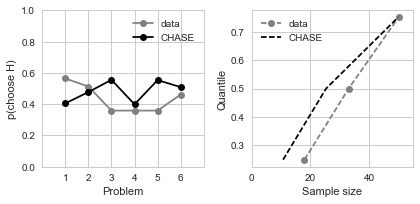

In [320]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
axi = ax[0]
axi.plot(range(1, 7), cp[SIM_ID].values, '-o',
         color='gray', label='data')
axi.plot(range(1, 7), bf_cp[SIM_ID], '-o', color='black', label='CHASE')
axi.set_ylim(0, 1)
axi.set_xlim(0, 7)
axi.set_xticks(range(1,7))
axi.set_xlabel('Problem')
axi.set_ylabel('p(choose H)')
axi.legend()

axi = ax[1]
axi.plot(quant[SIM_ID], [.25, .5, .75], '--o', color='gray', label='data')
axi.plot(bf_quant[SIM_ID], [.25, .5, .75], '--x', color='black', label='CHASE')

axi.set_xlim(0, 55)
axi.legend(loc='upper left')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')

plt.tight_layout()
plt.show()

# Old

In [ ]:
#data = pd.read_csv('paper/data/hertwig2004/hertwig2004_trialdata.csv', index_col=0).reset_index()
#data.problem = data.problem - 1
#data.option = 1 - data.option
#data.loc[(data.choice!=-1), 'choice'] = 1 - data.loc[(data.choice!=-1)].choice

In [ ]:
#ss = data.groupby(['subject', 'problem']).apply(lambda d: pd.Series({'samplesize': d.shape[0]})).reset_index()
#cutoff = ss.samplesize.mean() + 3*ss.samplesize.std()
#print cutoff

In [ ]:
problems_cv = {}
for pid in range(6):

    coding = max_var(problems[pid])
    print pid, coding
    problems_cv[pid] = np.array([problems[pid][coding[i]] for i in range(2)])

In [ ]:
HBWE_data = []

for i, grp in data.groupby(['subject', 'problem']):
    pid = grp.problem.values[0]
    
    ss = grp.shape[0]

    sampled_option = grp.option.values
    choice = grp.choice.values[-1]
    
    #coding = max_var(problems[pid])
    #sampled_option = np.array([coding[i] for i in grp.option.values])
    #choice = coding[grp.choice.values[-1]]
    
    if ss < cutoff:
        HBWE_data.append({'group': 0, 
                         'probid': pid,
                         'sampled_option': sampled_option,
                         'outcomes': grp.outcome.values,
                         'choice': choice,
                         'samplesize': ss})

### Baseline model

In [ ]:
from process_model_baseline import CHASEBaselineProcessModel

N_ITER = 1
SIM_ID = 'process_baseline_HBWE04'
OUTDIR = 'process_baseline_fitresults_HBWE04'
FIXED = {'minsamplesize': 2}
PARSETS = [['p_stop_geom']]

for parset in PARSETS:

    fitting = {p: PARS[p] for p in parset}
    m = CHASEBaselineProcessModel()
    results = fit_mlh(m, problems, HBWE_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [448]:
results

,iteration,success,nllh,k,N,bic,p_stop_geom
0,0,True,696.178344,1,150,1397.367324,0.053418


### Geom + two-stage

In [ ]:
from process_model_2stage import CHASETwoStageProcessModel

N_ITER = 1
SIM_ID = 'process_2stage_HBWE04'
OUTDIR = 'process_2stage_fitresults_HBWE04'

FIXED = {'minsamplesize': 2,
         'p_stop_geom': .053418}
PARSETS = [['pow_gain', 'prelec_elevation', 'prelec_gamma', 's']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASETwoStageProcessModel()
    results = fit_mlh(m, problems, HBWE_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [451]:
results

,iteration,success,nllh,k,N,bic,pow_gain,prelec_elevation,prelec_gamma,s
0,0,True,664.271416,4,150,1348.585372,0.363671,0.31345,1.542747,2.729099


In [452]:
pred = {}
m = CHASETwoStageProcessModel()
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_switch': .25,
            'p_stop_geom': .053418,
            'pow_gain': results.loc[0]['pow_gain'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            's': results.loc[0]['s'],
            'max_T': 1000,
            'N': 1000}
    pred[pid] = m(problems[pid], pars)

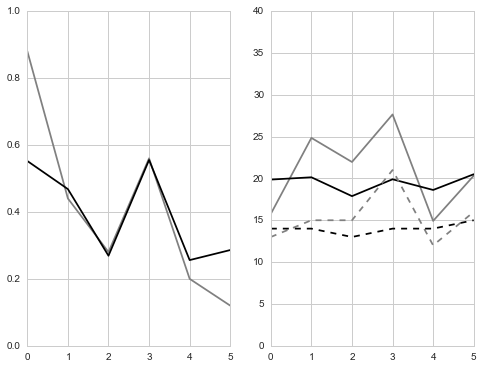

In [453]:
data = pd.read_csv('paper/data/hertwig2004_data.csv', index_col=0)

fig, axi = plt.subplots(1, 2, figsize=(8,6))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,40)

plt.show()

### CHASE + geom

In [ ]:
SIM_ID = 'process_HBWE04'
OUTDIR = 'process_fitresults_HBWE04'
FIXED = {'minsamplesize': 2,
         'p_fixed': 1,
         'p_stop_geom': .053418}
PARSETS = [['tau', 'lambda', 'pow_gain', 'prelec_elevation', 'prelec_gamma']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform-fixed')
    results = fit_mlh(m, problems, HBWE_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [455]:
results

,iteration,success,nllh,k,N,bic,lambda,pow_gain,prelec_elevation,prelec_gamma,tau
0,0,True,716.13854,5,150,1457.330257,-0.000852,0.808129,0.995768,1.261691,0.643931


In [456]:
pred = {}
arr = []
for d in HBWE_data:
    pid = d['probid']
    pars = {'probid': d['probid'],
            'obs': d,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': .053418,
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    res = m(problems[pid], pars)
    arr.append([d['probid'], d['choice'], d['samplesize'], res['cp_B']])
    
df = pd.DataFrame(arr, columns=['probid', 'choice', 'samplesize', 'cp'])

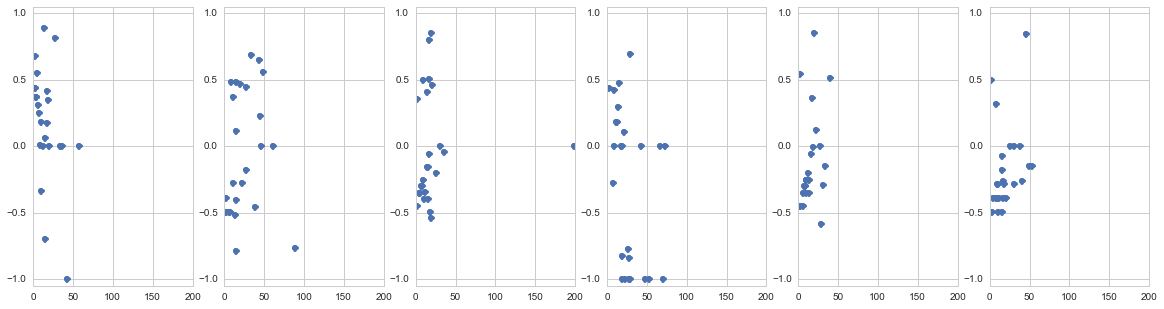

In [457]:
fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
    axi.set_xlim(0,200)
plt.show()

In [461]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform-fixed')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': .053418,
            'p_switch': .25,
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)

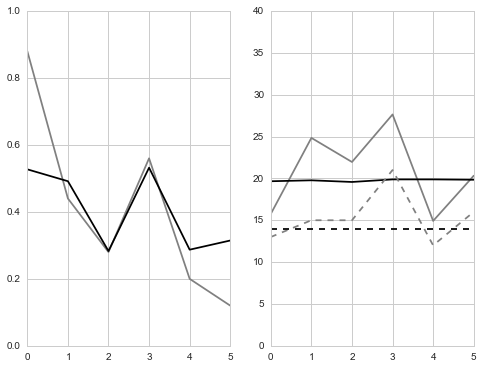

In [462]:
data = pd.read_csv('paper/data/hertwig2004_data.csv', index_col=0)

fig, axi = plt.subplots(1, 2, figsize=(8,6))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,40)

plt.show()

### CHASE (optional stopping)

In [ ]:
N_ITER = 1
SIM_ID = 'process_hertwig2004'
OUTDIR = 'process_fitresults_hertwig2004'

FIXED = {'minsamplesize': 2,
         'p_switch': .25}
PARSETS = [['theta', 'tau', 'p_stay', 'pow_gain', 'prelec_elevation', 'prelec_gamma']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform')
    results = fit_mlh(m, problems, HBWE_data, 
                      SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

In [428]:
results

,iteration,success,nllh,k,N,bic,p_stay,pow_gain,prelec_elevation,prelec_gamma,tau,theta
0,0,False,1305.835059,6,150,2641.73393,0.100995,0.561866,1.208618,1.073574,0.601972,2.784131


In [429]:
m = CHASEProcessModel(problems=problems,
                      startdist='uniform')
pred = {}
arr = []
for d in HBWE_data:
    pid = d['probid']
    pars = {'probid': d['probid'],
            'obs': d,
            'minsamplesize': 2,
            'p_fixed': 0,
            'tau': results.loc[0]['tau'],
            'theta': results.loc[0]['theta'],
            'p_stay': results.loc[0]['p_stay'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    res = m(problems[pid], pars)
    arr.append([d['probid'], d['choice'], d['samplesize'], res['cp_B']])
    
df = pd.DataFrame(arr, columns=['probid', 'choice', 'samplesize', 'cp'])

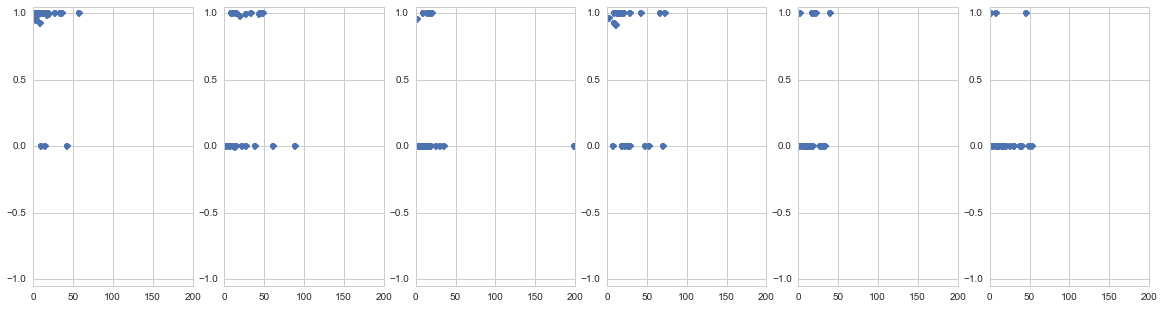

In [430]:
fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
    axi.set_xlim(0,200)
plt.show()

In [432]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_switch': .25,
            'theta': results.loc[0]['theta'],
            'tau': results.loc[0]['tau'],
            'p_stay': results.loc[0]['p_stay'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)

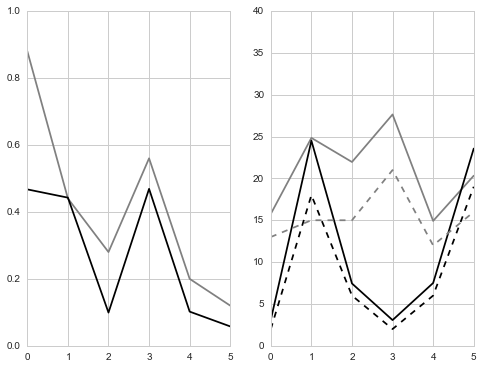

In [433]:
data = pd.read_csv('paper/data/hertwig2004_data.csv', index_col=0)

fig, axi = plt.subplots(1, 2, figsize=(8,6))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,40)

plt.show()

# Hau et al. (2008) - Experiment 1

In [ ]:
from mypy.explib.hau2008 import hau2008
HPKH1_data = hau2008.trial_data(study=1)

### Baseline

In [ ]:
from process_model_baseline import CHASEBaselineProcessModel

N_ITER = 1
SIM_ID = 'process_baseline_HPKH1'
OUTDIR = 'process_baseline_fitresults_HPKH1'
FIXED = {'minsamplesize': 2}
PARSETS = [['p_stop_geom']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEBaselineProcessModel()
    results = fit_mlh(m, problems, HPKH1_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [435]:
results

,iteration,success,nllh,k,N,bic,p_stop_geom
0,0,True,971.079115,1,230,1947.596308,0.07666


### Two-stage + geom

In [ ]:
from process_model_2stage import CHASETwoStageProcessModel
N_ITER = 1
SIM_ID = 'process_2stage_HPKH1'
OUTDIR = 'process_2stage_fitresults_HPKH1'
FIXED = {'minsamplesize': 2,
         'p_stop_geom': .07666}
PARSETS = [['pow_gain', 'prelec_elevation', 'prelec_gamma', 's']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASETwoStageProcessModel()
    results = fit_mlh(m, problems, HPKH1_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [437]:
results

,iteration,success,nllh,k,N,bic,pow_gain,prelec_elevation,prelec_gamma,s
0,0,True,902.001973,4,230,1825.756263,0.318952,0.60701,0.65675,4.775384


In [438]:
pred = {}
m = CHASETwoStageProcessModel()
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': .07666,
            'pow_gain': results.loc[0]['pow_gain'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            's': results.loc[0]['s'],
            'max_T': 1000,
            'N': 1000}
    pred[pid] = m(problems[pid], pars)

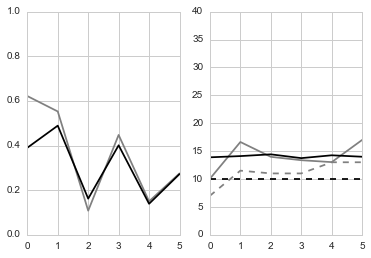

In [440]:
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==1]

fig, axi = plt.subplots(1, 2, figsize=(6,4))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,40)

plt.show()

### CHASE + geom

In [ ]:
N_ITER = 1
SIM_ID = 'process_HPKH1'
OUTDIR = 'process_fitresults_HPKH1'

FIXED = {'minsamplesize': 2,
         'p_fixed': 1,
         'p_switch': .185,
         'p_stop_geom': .07666}

PARSETS = [['tau', 'lambda', 'pow_gain', 'prelec_elevation', 'prelec_gamma']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform-fixed')
    results = fit_mlh(m, problems, HPKH1_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [464]:
results

,iteration,success,nllh,k,N,bic,lambda,pow_gain,prelec_elevation,prelec_gamma,tau
0,0,True,978.880092,5,230,1984.95058,0.000303,0.615612,1.175495,1.13464,0.540726


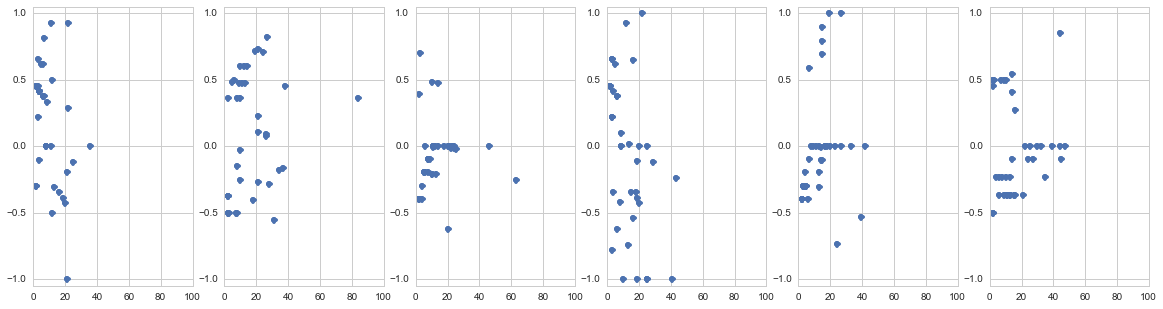

In [469]:
pred = {}
arr = []
for d in HPKH1_data:
    pid = d['probid']
    pars = {'probid': d['probid'],
            'obs': d,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': .07666,
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    res = m(problems[pid], pars)
    arr.append([d['probid'], d['choice'], d['samplesize'], res['cp_B']])
    
df = pd.DataFrame(arr, columns=['probid', 'choice', 'samplesize', 'cp'])

fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
    axi.set_xlim(0,100)
plt.show()

In [470]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform-fixed')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': .07666,
            'p_switch': .185,
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)

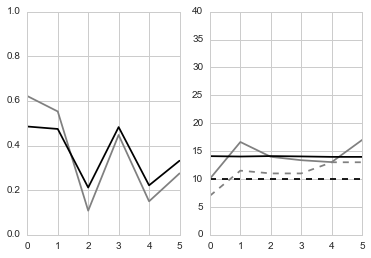

In [471]:
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==1]

fig, axi = plt.subplots(1, 2, figsize=(6,4))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,40)

plt.show()

### CHASE (optional)

In [446]:
N_ITER = 1
SIM_ID = 'process_HPKH1'
OUTDIR = 'process_fitresults_HPKH1'

FIXED = {'minsamplesize': 2,
         'p_switch': .185}
PARSETS = [['theta', 'tau', 'p_stay', 'pow_gain', 'prelec_elevation', 'prelec_gamma']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform')
    results = fit_mlh(m, problems, HPKH1_data, 
                      SIM_ID, FIXED, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

p_stay	pow_gain	prelec_elevation	prelec_gamma	tau	theta
[ 0.1  1.   1.   1.   0.5  3. ] 2218.26060337 29.2593390942
[ 0.105  1.     1.     1.     0.5    3.   ] 2214.81868901 30.4063830376
[ 0.1   1.05  1.    1.    0.5   3.  ] 2225.2878659 31.8709230423
[ 0.1   1.    1.05  1.    0.5   3.  ] 2213.92925523 33.0243399143
[ 0.1   1.    1.    1.05  0.5   3.  ] 2212.7794734 32.9617190361
[ 0.1    1.     1.     1.     0.525  3.   ] 2196.50652517 31.0505108833
[ 0.1   1.    1.    1.    0.5   3.15] 2224.99277198 30.456193924
[ 0.102  0.95   1.017  1.017  0.508  3.05 ] 2207.18330184 30.4067790508
[ 0.102  0.983  1.022  1.022  0.511  2.867] 2191.41094463 30.4521679878
[ 0.103  0.975  1.033  1.033  0.517  2.725] 2149.34119405 27.1496319771
[ 0.103  0.975  1.033  1.033  0.517  2.925] 2205.91976808 26.9705290794
[ 0.098  0.967  1.044  1.044  0.522  2.9  ] 2174.99396264 28.9825470448
[ 0.102  0.956  0.993  1.059  0.53   2.867] 2149.09493142 28.6417989731
[ 0.103  0.933  0.964  1.089  0.544  2.8  ] 214

KeyboardInterrupt: 

In [ ]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'theta': results.loc[0]['theta'],
            'tau': results.loc[0]['tau'],
            'p_switch': .25,
            #'phi': results.loc[0]['phi'],
            'p_fixed': results.loc[0]['p_fixed'],
            'p_stop_geom': results.loc[0]['p_stop_geom'],
            #'prelec_gamma': results.loc[0]['prelec_gamma'],
            #'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)

In [ ]:
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==1]

In [ ]:
fig, ax = plt.subplots()
ax.plot([data[data.problem==pid].choice.mean() for pid in problems])
ax.plot([pred[pid]['p_resp'][1] for pid in problems])
ax.set_ylim(0,1)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems])
ax.plot([pred[pid]['samplesize'].mean() for pid in problems])
ax.set_ylim(0,40)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems])
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems])
ax.set_ylim(0,40)
plt.show()

# Hau et al (2008) - Experiment 2

In [ ]:
HPKH2_data = hau2008.trial_data(study=2)

In [472]:
# confirm the right choice proportions and sample sizes
for pid in range(6):
    data = filter(lambda d: d['probid']==pid, HPKH2_data)
    print pid, np.round(np.mean([d['choice'] for d in data]), 2), np.median([d['samplesize'] for d in data])

0 0.56 27.0
1 0.51 38.0
2 0.36 27.0
3 0.36 35.0
4 0.36 34.0
5 0.46 33.0


In [ ]:
arr = []
for d in HPKH2_data:
    sampled_option = d['sampled_option']
    outcomes = d['outcomes']
    sum_L = np.sum(outcomes[sampled_option==0])
    sum_H = np.sum(outcomes[sampled_option==1])
    arr.append([d['probid'], sum_H - sum_L, d['choice']])
df = pd.DataFrame(arr, columns=['problem', 'diff', 'choice'])

sns.lmplot(x="diff", y="choice", data=df,
           logistic=True, y_jitter=.03)

sns.lmplot(x="diff", y="choice", data=df[(df['diff'] < 100) & (df['diff'] > -100)],
           logistic=True, y_jitter=.03)

### Baseline model

In [ ]:
from process_model_baseline import CHASEBaselineProcessModel
N_ITER = 1
SIM_ID = 'process_baseline_HPKH2'
OUTDIR = 'process_baseline_fitresults_HPKH2'
FIXED = {'minsamplesize': 2}
PARSETS = [['p_stop_geom', 'p_switch']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEBaselineProcessModel()
    results = fit_mlh(m, problems, HPKH2_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [474]:
results

,iteration,success,nllh,k,N,bic,p_stop_geom
0,0,True,1244.818071,1,234,2495.091464,0.02627


### Geom + two-stage

In [ ]:
from process_model_2stage import CHASETwoStageProcessModel

N_ITER = 1
SIM_ID = 'process_2stage_HPKH2'
OUTDIR = 'process_2stage_fitresults_HPKH2'

FIXED = {'minsamplesize': 2,
         'p_stop_geom': P_STOP_GEOM['HPKH2']}
PARSETS = [['pow_gain', 'prelec_elevation', 'prelec_gamma', 's']]

for parset in PARSETS:

    fitting = {p: PARS[p] for p in parset}
    m = CHASETwoStageProcessModel()
    results = fit_mlh(m, problems, HPKH2_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [488]:
results

,iteration,success,nllh,k,N,bic,pow_gain,prelec_elevation,prelec_gamma,s
0,0,True,1222.658089,4,234,2467.137463,0.515943,0.719596,0.766813,1.699336


In [490]:
pred = {}
m = CHASETwoStageProcessModel()
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': P_STOP_GEOM['HPKH2'],
            'pow_gain': results.loc[0]['pow_gain'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            's': results.loc[0]['s'],
            'max_T': 1000,
            'N': 1000}
    pred[pid] = m(problems[pid], pars)

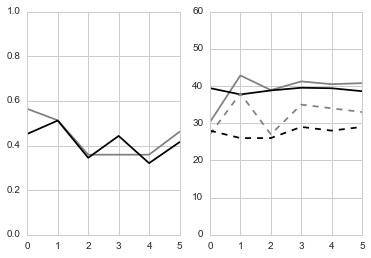

In [491]:
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==2]

fig, axi = plt.subplots(1, 2, figsize=(6,4))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,60)

plt.show()

In [ ]:
llh = {pid: 0 for pid in range(6)}
for i, row in df.iterrows():
    probid = row['probid']
    choice = row['choice']
    cp = row['cp']
    if choice == 0:
        llh[probid] += np.log(pfix(1 - cp))
    else:
        llh[probid] += np.log(pfix(cp))

In [ ]:
llh

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
plt.show()

In [ ]:
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==2]

fig, ax = plt.subplots(figsize=(6,4))
ax.plot([data[data.problem==pid].choice.mean() for pid in problems])
ax.plot(df.groupby('probid').apply(lambda d: d.cp.mean()).values)
ax.set_ylim(0,1)
plt.show()

### CHASE + geom

In [ ]:
N_ITER = 1
SIM_ID = 'process_HPKH2'
OUTDIR = 'process_fitresults_HPKH2'

FIXED = {'minsamplesize': 2,
         'p_fixed': 1,
         'p_stop_geom': P_STOP_GEOM['HPKH2']}

PARSETS = [['tau', 'lambda', 'pow_gain', 'prelec_elevation', 'prelec_gamma']]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='uniform-fixed')
    results = fit_mlh(m, problems, HPKH2_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [493]:
results

,iteration,success,nllh,k,N,bic,lambda,pow_gain,prelec_elevation,prelec_gamma,tau
0,0,True,1316.584042,5,234,2660.444689,0.000433,0.833131,1.167528,0.761687,0.655597


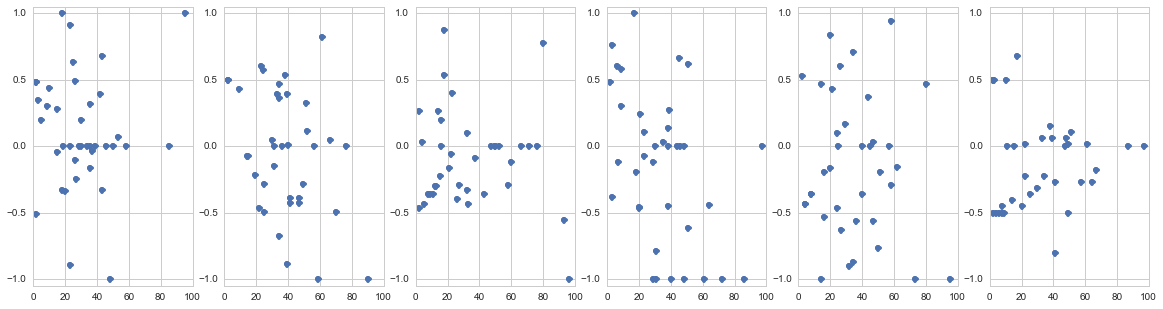

In [483]:
pred = {}
arr = []
for d in HPKH2_data:
    pid = d['probid']
    pars = {'probid': d['probid'],
            'obs': d,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': P_STOP_GEOM['HPKH2'],
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    res = m(problems[pid], pars)
    arr.append([d['probid'], d['choice'], d['samplesize'], res['cp_B']])
    
df = pd.DataFrame(arr, columns=['probid', 'choice', 'samplesize', 'cp'])

fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
    axi.set_xlim(0,100)
plt.show()

In [498]:
for pid in range(6):
    print pid
    print problems[pid]

0
[[[ 3.   1. ]
  [ 0.   0. ]]

 [[ 4.   0.8]
  [ 0.   0.2]]]
1
[[[ 3.    0.25]
  [ 0.    0.75]]

 [[ 4.    0.2 ]
  [ 0.    0.8 ]]]
2
[[[-32.    0.1]
  [  0.    0.9]]

 [[ -3.    1. ]
  [  0.    0. ]]]
3
[[[-4.   0.8]
  [ 0.   0.2]]

 [[-3.   1. ]
  [ 0.   0. ]]]
4
[[[  3.    1. ]
  [  0.    0. ]]

 [[ 32.    0.1]
  [  0.    0.9]]]
5
[[[  3.00000000e+00   2.50000000e-01]
  [  0.00000000e+00   7.50000000e-01]]

 [[  3.20000000e+01   2.50000000e-02]
  [  0.00000000e+00   9.75000000e-01]]]


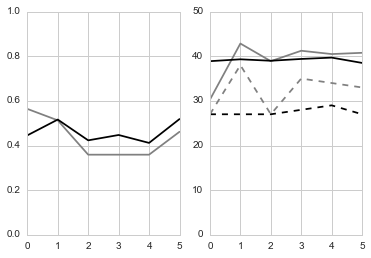

In [495]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform-fixed')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'p_fixed': 1,
            'p_stop_geom': P_STOP_GEOM['HPKH2'],
            'p_switch': P_SWITCH['HPKH2'],
            'tau': results.loc[0]['tau'],
            'lambda': results.loc[0]['lambda'],
            'prelec_gamma': results.loc[0]['prelec_gamma'],
            'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)
    
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==2]

fig, axi = plt.subplots(1, 2, figsize=(6,4))
ax = axi[0]
ax.plot([data[data.problem==pid].choice.mean() for pid in problems], color='gray')
ax.plot([pred[pid]['p_resp'][1] for pid in problems], color='black')
ax.set_ylim(0,1)

ax = axi[1]
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems], '-', color='gray')
ax.plot([pred[pid]['samplesize'].mean() for pid in problems], '-', color='black')
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], '--', color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], '--', color='black')
ax.set_ylim(0,50)

plt.show()

In [ ]:
llh = {pid: 0 for pid in range(6)}
for i, row in df.iterrows():
    probid = row['probid']
    choice = row['choice']
    cp = row['cp']
    if choice == 0:
        llh[probid] += np.log(pfix(1 - cp))
    else:
        llh[probid] += np.log(pfix(cp))

In [ ]:
llh

In [ ]:
{0: -26.994788602372655,
 1: -22.985235037285271,
 2: -16.927245225174545,
 3: -27.251149138644049,
 4: -26.746905508212905,
 5: -19.132769547444727}

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(20,5))

for pid in range(6):
    dfp = df[df.probid==pid]
    axi = ax[pid]
    axi.plot(dfp.samplesize, dfp.choice - dfp.cp, 'o')
    axi.set_ylim(-1.05, 1.05)
plt.show()

In [ ]:
lm = sns.lmplot(x="samplesize", y="choice", row="probid",
                data=df, logistic=False, y_jitter=.03)
for ax in lm.axes.ravel():
    ax.set_ylim(-.05,1.05)
    ax.set_xlim(0,100)

In [ ]:
lm = sns.lmplot(x="cp", y="choice", row="probid",
                data=df, logistic=False, y_jitter=.03)
for ax in lm.axes.ravel():
    ax.set_ylim(-.05,1.05)
    ax.set_xlim(-.05,1.05)

### CHASE (optional stopping)

In [ ]:
N_ITER = 1
SIM_ID = 'process_HPKH2'
OUTDIR = 'process_fitresults_HPKH2'

FIXED = {'minsamplesize': 2,
         'p_switch': .1}

PARSETS = [#['theta', 'tau', 'pow_gain'],
           #['theta', 'tau', 'p_fixed', 'prelec_gamma', 'prelec_elevation'],
            ['theta', 'pow_gain', 'prelec_gamma', 'prelec_elevation']
           #['theta', 'tau', 'prelec_gamma', 'prelec_elevation', 'prelec_gamma_loss', 'prelec_elevation_loss', 'pow_gain']
          ]

for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    m = CHASEProcessModel(problems=problems,
                          startdist='indifferent')
    results = fit_mlh(m, problems, HPKH2_data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)

In [ ]:
pred = {}
m = CHASEProcessModel(problems=problems,
                      startdist='uniform')
for pid in problems:
    pars = {'probid': pid,
            'minsamplesize': 2,
            'theta': results.loc[0]['theta'],
            'tau': results.loc[0]['tau'],
            'p_switch': .1,
            #'phi': results.loc[0]['phi'],
            #'p_fixed': results.loc[0]['p_fixed'],
            #'p_stop_geom': results.loc[0]['p_stop_geom'],
            #'prelec_gamma': results.loc[0]['prelec_gamma'],
            #'prelec_elevation': results.loc[0]['prelec_elevation'],
            'pow_gain': results.loc[0]['pow_gain'],
            'max_T': 1000,
            'N': 10000}
    pred[pid] = m(problems[pid], pars)
    
data = pd.read_csv('paper/data/hau_data.csv', index_col=0)
data = data[data.group==2]

In [ ]:
fig, ax = plt.subplots()
ax.plot([data[data.problem==pid].choice.mean() for pid in problems])
ax.plot([pred[pid]['p_resp'][1] for pid in problems])
ax.set_ylim(0,1)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot([data[data.problem==pid].samplesize.mean() for pid in problems])
ax.plot([pred[pid]['samplesize'].mean() for pid in problems])
ax.set_ylim(0,50)
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot([np.median(data[data.problem==pid].samplesize.values) for pid in problems], color='gray')
ax.plot([np.median(pred[pid]['samplesize']) for pid in problems], color='black')
ax.set_ylim(0,40)
plt.show()

In [ ]:
pred[0]['samplesize']

In [ ]:
fig, axi = plt.subplots(2, 6, figsize=(15,8))

for pid in range(6):
    sns.distplot(data[data.problem==pid].samplesize.values, kde=False, ax=axi[1][pid])
    sns.distplot(pred[pid]['samplesize'], kde=False, ax=axi[0][pid], color='gray')
    
for i in range(2):
    for j in range(6):
        axi[i][j].set_xlim(0,200)

In [ ]:
# show the fitting results for the model with the lowest BIC
fitting = {p: PARS[p] for p in PARSETS[0]}
print best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)

m = CHASEModel(drift='cpt', startdist='indifferent')
pred = predict_from_result(m, problems, SIM_ID, FIXED, 
                           fitting = fitting, 
                           outdir=OUTDIR)

# Recovery

In [ ]:
from cogmod import cpt as cptmodel

def fit_chase(problems, data, fit_pars):
        
    FIXED = {'dt': .1}
    N_ITER = 1
    SIM_ID = 'recover_process_data'
    OUTDIR = 'chase_fitresults_recover_process_data'

    fitting = {p: PARS[p] for p in fit_pars}

    # initialize the model
    m = CHASEModel(drift='cpt',
                   startdist='indifferent',
                   problems=problems)

    # fit
    results = fit_mlh(m, problems, data, 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR, quiet=False)
    best = best_result(SIM_ID, FIXED, fitting, outdir=OUTDIR)
    pred = predict_from_result(m, problems, SIM_ID, FIXED, 
                               fitting = fitting, 
                               outdir=OUTDIR)

    return best, pred


PARS = {'theta': [1, 20],
        'c': [.01, 2, .5],
        'p_stay': [0, 1, .5],
        'tau': [0, 1, .5],
        'prelec_gamma': [0, 5, 1.],
        'prelec_elevation': [0, 5, 1.],
        'pow_gain': [0., np.inf, 1.],
        'w_loss': [0., np.inf, 1.],
        'lambda': [-2, 2, 0.],}

fitting_cpt = {'s': [0, np.inf, 1.],
               'prelec_gamma': [0, 10, 1.]}

def predicted_samplesize(pred):
    cp = pred['p_resp'][1]
    ss = pred['p_stop_cond'][:,1]*cp + pred['p_stop_cond'][:,0]*(1-cp)
    ss = ss/float(ss.sum())
    return np.array(ss)

def observed_samplesize(data):
    bc = np.bincount(data.samplesize)
    return bc/float(bc.sum())

def predicted_cp(pred):
    cp = pred['p_resp'][1]
    return cp

def observed_cp(data):
    return data.choice.mean()

In [ ]:
arr = np.genfromtxt('paper/data/six_problems.csv', delimiter=',')
problems = {i: arr[i].reshape((2,2,2)) for i in range(len(arr))}
#problems = {i: arr[i].reshape((2,2,2)) for i in range(1)}
#problems = [arr[i].reshape((2,2,2)) for i in range(len(arr))]

In [ ]:
with open('/Users/markant/code/chase/chase/paper/glockner_exp3_problems.pkl', 'r') as f:
    glockner_exp3_problems = pickle.load(f)

problems = {}
for p in glockner_exp3_problems:
    if np.sum(glockner_exp3_problems[p][:,:,0].ravel() < 0)==0:
        if np.random.random() < .05:
            problems[p] = glockner_exp3_problems[p]

In [ ]:
with open('/Users/markant/code/chase/chase/paper/data/tpt_problems.pkl', 'r') as f:
    problems = pickle.load(f)